# 0.0 IMPORTS

In [1]:
import re
import numpy                 as np
import pandas                as pd

import seaborn               as sns
import matplotlib.patches    as mpatches
import scikitplot            as skplt
import plotly.express        as px
import umap.umap_            as umap

from sklearn import cluster  as c
from sklearn import metrics  as m

from matplotlib              import pyplot as plt
from IPython.core.display    import HTML
from IPython.display         import Image

from sklearn                 import preprocessing as pp
from yellowbrick.cluster     import KElbowVisualizer, SilhouetteVisualizer

## 0.1 Helper Functions

In [2]:
def personal_settings():   
    display(HTML('<style>.container{width:80% !important;}</style>'))
    np.set_printoptions(suppress=True)
    pd.options.display.float_format = '{:.2f}'.format
    pd.options.mode.chained_assignment = None
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [20,10]
    plt.rcParams['font.size'] = 24
    
    sns.set()

In [3]:
personal_settings()

## 0.2 Load Data

In [4]:
df_raw = pd.read_csv('../data/OnlineRetail.csv')

# 1 DATA DESCRIPTION

In [5]:
df1 = df_raw.copy()

In [6]:
df1.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.00,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.00,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.00,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.00,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.00,United Kingdom


## 1.1 Data Dimensions

In [7]:
print(df1.shape[0], 'rows')
print(df1.shape[1], 'columns')

541909 rows
8 columns


## 1.2 Rename columns

In [8]:
df1.columns 

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [9]:
cols_new = ['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date','unit_price', 'customer_id', 'country']
df1.columns = cols_new

## 1.2 Data Descriptions

* `invoice_no` | A 6-digit integral number uniquely assigned to each transaction. If this code starts with letter `c`, it indicates a cancellation. 
* `stock_code` | A 5-digit integral number uniquely assigned to each distinct product.   
* `description` | Product name. 
* `quantity` | The quantities of each product (item) per transaction.  
* `invoice_date` | The day and time when each transaction was generated.    
* `unit_price` | Product price per unit in sterling.
* `customer_iD` | A 5-digit integral number uniquely assigned to each customer.    
* `country` | The name of the country where each customer resides.   

## 1.3 Data Types

In [10]:
description = []

for i in df1.columns:
    description.append([
        i,
        df1[i].dtypes,
        df1[i].nunique(),
        df1[i].drop_duplicates().sample(2).values
    ])

pd.DataFrame(data = description, columns=['attributes', 'dtypes', 'nunique', 'sample'])

,attributes,dtypes,nunique,sample
0,invoice_no,object,25900,"[560191, 578804]"
1,stock_code,object,4070,"[21425, 23214]"
2,description,object,4223,"[RUBY GLASS CLUSTER BRACELET, LA PALMIERA TILE..."
3,quantity,int64,722,"[701, 245]"
4,invoice_date,object,23260,"[2011-06-13 14:49:00, 2011-06-15 14:14:00]"
5,unit_price,float64,1630,"[576.18, 264.65]"
6,customer_id,float64,4372,"[15119.0, 12365.0]"
7,country,object,38,"[Austria, Hong Kong]"


## 1.4 Check NA

In [11]:
description = []

for i in df1.columns:
    description.append([
        i,
        df1[i].isna().sum(),
        round((df1[i].isna().sum()/len(df1))*100)
    ])

pd.DataFrame(data = description, columns=['attributes','null', '%null'])

,attributes,null,%null
0,invoice_no,0,0
1,stock_code,0,0
2,description,1454,0
3,quantity,0,0
4,invoice_date,0,0
5,unit_price,0,0
6,customer_id,135080,25
7,country,0,0


## 1.5 Replace NA

Since the total `customer_id` nulls represent 25% of the dataset, we are missing a lot of data about the customer's behavior. Therefore, we will replace the nulls by grouping by `invoice_no`, with values greater than the maximum `customer_id` in the dataset. Of course, in this case these `customer_id` cannot be defined as part of the customer Insiders, because in this context we don't have who these customers are, but by using them we can use them to improve our clustering.  

In [12]:
df_missing = df1.loc[df1['customer_id'].isna(), :]
df_not_missing = df1.loc[~df1['customer_id'].isna(), :]

In [13]:
df_not_missing['customer_id'].max()

18287.0

In [14]:
# creating reference
df_backup = pd.DataFrame(df_missing['invoice_no'].drop_duplicates())
df_backup['customer_id'] = np.arange(19000, 19000+len(df_backup), 1)

# merge 
df1 = pd.merge(df1, df_backup, on='invoice_no', how='left')

# coalesce 
df1['customer_id'] = df1['customer_id_x'].combine_first(df1['customer_id_y'])

# drop extra columns
df1 = df1.drop(columns=['customer_id_x', 'customer_id_y'], axis=1)

In [15]:
df1

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,United Kingdom,17850.00
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,United Kingdom,17850.00
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,United Kingdom,17850.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,United Kingdom,17850.00
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,United Kingdom,17850.00
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,France,12680.00
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,France,12680.00
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,France,12680.00
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,France,12680.00


In [16]:
df1.isna().sum()

invoice_no         0
stock_code         0
description     1454
quantity           0
invoice_date       0
unit_price         0
country            0
customer_id        0
dtype: int64

## 1.6 Change dtypes

In [17]:
# invoice_date
df1['invoice_date'] = pd.to_datetime(df1['invoice_date']).dt.normalize()

# customer_id
df1['customer_id'] = np.int64(df1['customer_id'])

In [18]:
df1.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
country                 object
customer_id              int64
dtype: object

In [19]:
df1.head(2)

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01,2.55,United Kingdom,17850
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01,3.39,United Kingdom,17850


## 1.6 Descriptive Statistics

In [20]:
df_num1 = df1.select_dtypes(include = ['int64', 'float64'])
df_cat1 = df1.select_dtypes(exclude = ['int64', 'float64', 'datetime64[ns]'])

### 1.6.1 Numeric Attributes

In [21]:
# central tendency - mean, median
ct1 = pd.DataFrame(df_num1.apply(np.mean)).T
ct2 = pd.DataFrame(df_num1.apply(np.median)).T

# dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(df_num1.apply(np.std)).T 
d2 = pd.DataFrame(df_num1.apply(min)).T
d3 = pd.DataFrame(df_num1.apply(max)).T
d4 = pd.DataFrame(df_num1.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(df_num1.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(df_num1.apply(lambda x: x.kurtosis())).T

# concat
num1_summary = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
num1_summary.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
num1_summary

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,quantity,-80995.00,80995.00,161990.00,9.55,3.00,218.08,-0.26,119769.16
1,unit_price,-11062.06,38970.00,50032.06,4.61,2.08,96.76,186.51,59005.72
2,customer_id,12346.00,22709.00,10363.00,16688.84,16249.00,2911.41,0.49,-0.80


Can negative `quantity` be a return?     
Can `unit_price` equal to zero be a promotion?

#### Quantity

In [22]:
df1.sort_values('quantity').head(10)

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
540422,C581484,23843,"PAPER CRAFT , LITTLE BIRDIE",-80995,2011-12-09,2.08,United Kingdom,16446
61624,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,2011-01-18,1.04,United Kingdom,12346
225529,556690,23005,printing smudges/thrown away,-9600,2011-06-14,0.00,United Kingdom,20914
225530,556691,23005,printing smudges/thrown away,-9600,2011-06-14,0.00,United Kingdom,20915
4287,C536757,84347,ROTATING SILVER ANGELS T-LIGHT HLDR,-9360,2010-12-02,0.03,United Kingdom,15838
225528,556687,23003,Printing smudges/thrown away,-9058,2011-06-14,0.00,United Kingdom,20913
115818,546152,72140F,throw away,-5368,2011-03-09,0.00,United Kingdom,19837
431381,573596,79323W,"Unsaleable, destroyed.",-4830,2011-10-31,0.00,United Kingdom,22229
341601,566768,16045,NaN,-3667,2011-09-14,0.00,United Kingdom,21714
323458,565304,16259,NaN,-3167,2011-09-02,0.00,United Kingdom,21629


#### Customer Id

Let's take a look at the `custumers_id` for the two smallest `quantity` values.

In [23]:
df1.loc[df1['customer_id'] == 16446, :]

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
194354,553573,22980,PANTRY SCRUBBING BRUSH,1,2011-05-18,1.65,United Kingdom,16446
194355,553573,22982,PANTRY PASTRY BRUSH,1,2011-05-18,1.25,United Kingdom,16446
540421,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2011-12-09,2.08,United Kingdom,16446
540422,C581484,23843,"PAPER CRAFT , LITTLE BIRDIE",-80995,2011-12-09,2.08,United Kingdom,16446


In [24]:
df1.loc[df1['customer_id'] == 12346, :]

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18,1.04,United Kingdom,12346
61624,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,2011-01-18,1.04,United Kingdom,12346


### 1.7.2 Categorical Attributes

In [25]:
df_cat1.head()

,invoice_no,stock_code,description,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,United Kingdom
1,536365,71053,WHITE METAL LANTERN,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,United Kingdom


#### Invoice No

In [26]:
aux1 = df1.loc[df1['invoice_no'].apply(lambda x: bool(re.search('[^0-9]+', x))), :]

display(aux1.sample(5))

print(aux1.shape[0], 'rows')

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
485826,C577688,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,-1,2011-11-21,7.95,United Kingdom,13890
256305,C559486,23236,DOILEY STORAGE TIN,-1,2011-07-08,2.89,United Kingdom,13047
229382,C557037,22192,BLUE DINER WALL CLOCK,-1,2011-06-16,8.50,United Kingdom,16814
14022,C537444,22580,ADVENT CALENDAR GINGHAM SACK,-8,2010-12-07,5.95,United Kingdom,14850
449039,C575081,23480,MINI LIGHTS WOODLAND MUSHROOMS,-5,2011-11-08,3.75,Sweden,12483


9291 rows


We know from the data description that `invoice` in what starts with C stands for returns.   
Another thing we discovered (in the `custumer_id` analysis) is that the database has the purchase and return invoice represented by different numbers, not just the 'C' in front.

#### Stock Code

In [27]:
# getting stock_code with just characters
aux2 = df1.loc[df1['stock_code'].apply(lambda x: bool(re.search('^[a-zA-Z]+$', x))), :]

display(aux2.sample(5))

aux2['stock_code'].unique()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
245687,558626,POST,POSTAGE,1,2011-06-30,18.00,Germany,12569
473280,576789,POST,POSTAGE,1,2011-11-16,18.00,Germany,12569
114568,546027,POST,POSTAGE,2,2011-03-09,15.00,Netherlands,12759
80261,543030,POST,POSTAGE,1,2011-02-02,18.00,France,12437
41448,539856,M,Manual,1,2010-12-22,1298.40,United Kingdom,19304


array(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY',
       'DCGSSGIRL', 'PADS', 'B', 'CRUK'], dtype=object)

Some `stock_code` we have an idea of what it means, such as "post", others we don't. Since we know that some do not represent product purchases, we will discard the lines with these categories later on.

#### Country

In [28]:
df1['country'].unique()

array(['United Kingdom', 'France', 'Australia', 'Netherlands', 'Germany',
       'Norway', 'EIRE', 'Switzerland', 'Spain', 'Poland', 'Portugal',
       'Italy', 'Belgium', 'Lithuania', 'Japan', 'Iceland',
       'Channel Islands', 'Denmark', 'Cyprus', 'Sweden', 'Austria',
       'Israel', 'Finland', 'Bahrain', 'Greece', 'Hong Kong', 'Singapore',
       'Lebanon', 'United Arab Emirates', 'Saudi Arabia',
       'Czech Republic', 'Canada', 'Unspecified', 'Brazil', 'USA',
       'European Community', 'Malta', 'RSA'], dtype=object)

In [29]:
len(df1['country'].unique())

38

In [30]:
df1['country'].value_counts(normalize=True).head(10)

United Kingdom   0.91
Germany          0.02
France           0.02
EIRE             0.02
Spain            0.00
Netherlands      0.00
Belgium          0.00
Switzerland      0.00
Portugal         0.00
Australia        0.00
Name: country, dtype: float64

For `country`, which represents the country where the purchase was made, we have that the majority was made from the United Kingdom, representing 91%.

In [31]:
df1[['customer_id', 'country']].drop_duplicates().groupby('country').count().reset_index().sort_values('customer_id', ascending=False)

,country,customer_id
36,United Kingdom,7587
14,Germany,95
13,France,90
10,EIRE,44
31,Spain,31
3,Belgium,25
33,Switzerland,24
27,Portugal,20
19,Italy,15
16,Hong Kong,15


# 2 DATA FILTERING

In [32]:
df2 = df1.copy()

In [33]:
# unit_price
df2 = df2.loc[df2['unit_price'] >= 0.04, :] # assuming that less than this value is gift

# categorical attributes
df2 = df2[~df2['stock_code'].isin(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY', 'DCGSSGIRL', 'PADS', 'B', 'CRUK'])]

# description
# at this point we will not use the feature description, since it is unlikely to influence the clustering
df2 = df2.drop(columns='description', axis=1)

# country
# For now, we will also not use countries, since 91% of the purchases were made from a single country. 
df2 = df2.drop(columns='country', axis=1)

# quantity
df2_cancelations = df2.loc[df1['quantity'] < 0, :]
df2_purchases = df2.loc[df1['quantity'] >= 0, :]

# 3.0  FEATURE ENGINEERING

In [34]:
df3 = df2.copy() 
df3_cancelations = df2_cancelations.copy()
df3_purchases = df2_purchases.copy()

## 3.1 Features Creation

In [35]:
# reference table
df_ref = df3.drop(['invoice_no', 'stock_code', 'quantity', 
                   'invoice_date', 'unit_price'], axis=1).drop_duplicates(ignore_index=True)

df_ref.head()

,customer_id
0,17850
1,13047
2,12583
3,13748
4,15100


####  Gross Revenue

In [36]:
# gross revenue
df3['gross_revenue'] = df3['quantity'] * df3['unit_price']

df_gross_revenue = df3[['customer_id', 'gross_revenue']].groupby('customer_id').sum().reset_index()

df_ref = pd.merge(df_ref, df_gross_revenue, on='customer_id', how='left')

In [37]:
df_ref.sort_values('gross_revenue').head()

,customer_id,gross_revenue
5615,22515,-1208.04
217,14213,-1192.20
3782,21005,-1096.14
1419,19439,-1050.15
794,19207,-966.92


It doesn't make sense to have clients with negative `gross_revenue`, since to have a product canceled you must have bought that product, and the smallest possible value of `gross_revenue` that makes sense is 0. So let's eliminate those negative values from our analysis.

In [38]:
df_ref = df_ref.loc[df_ref['gross_revenue'] >= 0].reset_index(drop = True)

In [39]:
df_ref.sort_values('gross_revenue').head()

,customer_id,gross_revenue
1205,13672,0.00
4092,18268,0.00
4827,14792,0.00
1350,12346,0.00
4722,13364,0.00


#### Mean Ticket 

In [40]:
df_mean_ticket = (df3[['customer_id', 'gross_revenue']].groupby('customer_id').mean()
                                                                              .reset_index()
                                                                              .rename(columns={'gross_revenue':'mean_ticket'}))

df_ref = pd.merge(df_ref, df_mean_ticket, on='customer_id', how='left')

#### Purchase Quantity

In [41]:
df_qtdpurchases = (df3_purchases[['customer_id', 'invoice_no']].drop_duplicates().groupby('customer_id')
                                                                                 .count()
                                                                                 .reset_index()
                                                                                 .rename(columns={'invoice_no': 'qtd_purchases'}))

df_ref = pd.merge(df_ref, df_qtdpurchases, on='customer_id', how='left')

#### Quantity of Products

In [42]:
df_qtdproducts = (df3_purchases[['customer_id', 'quantity']].groupby('customer_id').sum()
                                                                                   .reset_index()
                                                                                   .rename(columns={'quantity': 'qtd_products'}))
                                                        
                                                        
df_ref = pd.merge(df_ref, df_qtdproducts, on = 'customer_id', how ='left')

#### Basket Size | Average of Products Per Purchase

In [43]:
df_basket_size = (df3_purchases[['customer_id', 'invoice_no', 'quantity']].groupby('customer_id')
                                                                          .agg(n_purchase=('invoice_no', 'nunique'),
                                                                               n_products=('quantity', 'sum')).reset_index())

df_basket_size['avg_products'] = df_basket_size['n_products'] / df_basket_size['n_purchase']

df_ref = pd.merge(df_ref, df_basket_size[['customer_id', 'avg_products']], how='left', on='customer_id')

#### Average of Distinct Products Per Purchase

In [44]:
df_dist_products = (df2_purchases[['customer_id', 'invoice_no', 'stock_code']].groupby('customer_id')
                                                                              .agg(n_purchase=('invoice_no', 'nunique'),
                                                                                   n_products=('stock_code', 'nunique')).reset_index())

df_dist_products['avg_unique_products'] = df_dist_products['n_products'] / df_dist_products['n_purchase']

df_ref = pd.merge(df_ref, df_dist_products[['customer_id', 'avg_unique_products']], how='left', on='customer_id')

#### Recency | Days Since Last Purchase

In [45]:
df_recency = df3_purchases[['customer_id', 'invoice_date']].groupby('customer_id').max().reset_index()
df_recency['recency_days'] = (df3_purchases['invoice_date'].max() - df_recency['invoice_date']).dt.days
df_recency = df_recency[['customer_id', 'recency_days']].copy()

df_ref = pd.merge(df_ref, df_recency, on='customer_id', how='left')

#### Frequency of Purchase

In [46]:
df_frequency = (df3_purchases[['customer_id', 'invoice_no', 'invoice_date']].drop_duplicates()
                                                                            .groupby('customer_id')
                                                                            .agg(max_ = ('invoice_date', 'max'), 
                                                                                 min_ = ('invoice_date', 'min'),
                                                                                 days_= ('invoice_date', lambda x: ((x.max() - x.min()).days) + 1),
                                                                                 buy_ = ('invoice_no', 'count')).reset_index())

df_frequency['purchase_frequency'] = df_frequency[['buy_', 'days_']].apply(lambda x: x['buy_'] / x['days_'] if x['days_'] != 0 else 0, axis=1)

df_ref = pd.merge( df_ref, df_frequency[['customer_id', 'purchase_frequency']], on='customer_id', how='left' )

#### Quantity of Products Cancelled

In [47]:
df_cancelations = (df3_cancelations[['customer_id', 'quantity']].groupby('customer_id').sum()
                                                                                       .reset_index()
                                                                                       .rename(columns={'quantity':'qtd_cancelled_products'}))

df_cancelations['qtd_cancelled_products'] = df_cancelations['qtd_cancelled_products'] * -1

df_ref = pd.merge(df_ref, df_cancelations, how='left', on='customer_id')
df_ref.loc[df_ref['qtd_cancelled_products'].isna(), 'qtd_cancelled_products'] = 0
df_ref['qtd_cancelled_products'] = df_ref['qtd_cancelled_products'].astype(np.int64)

#### Cancelled Products Over Purchased Products

In [48]:
df_ref['cancelled_over_purchased'] = (df_ref[['qtd_products', 'qtd_cancelled_products']]
                                      .apply(lambda x: x['qtd_cancelled_products'] / x['qtd_products'], axis=1))

In [49]:
df_ref.head()

,customer_id,gross_revenue,mean_ticket,qtd_purchases,qtd_products,avg_products,avg_unique_products,recency_days,purchase_frequency,qtd_cancelled_products,cancelled_over_purchased
0,17850,5288.63,16.95,34,1733,50.97,0.62,372,17.00,40,0.02
1,13047,3089.10,15.92,9,1390,154.44,11.67,56,0.03,35,0.03
2,12583,6629.34,28.21,15,5028,335.20,7.60,2,0.04,50,0.01
3,13748,948.25,33.87,5,439,87.80,4.80,95,0.02,0,0.00
4,15100,635.10,105.85,3,80,26.67,0.33,333,0.07,22,0.28


In [50]:
df_ref.isna().sum()

customer_id                 0
gross_revenue               0
mean_ticket                 0
qtd_purchases               0
qtd_products                0
avg_products                0
avg_unique_products         0
recency_days                0
purchase_frequency          0
qtd_cancelled_products      0
cancelled_over_purchased    0
dtype: int64

# 4 EXPLORATORY DATA ANALYSIS

In [51]:
df4 = df_ref.copy()

# 5 DATA PREPARATION

In [52]:
df5 = df4.copy()

In [53]:
mms = pp.MinMaxScaler()

df5['gross_revenue'] = mms.fit_transform(df5[['gross_revenue']])
df5['mean_ticket'] = mms.fit_transform(df5[['mean_ticket']])
df5['qtd_purchases'] = mms.fit_transform(df5[['qtd_purchases']])
df5['qtd_cancelled_products'] = mms.fit_transform(df5[['qtd_cancelled_products']])
df5['cancelled_over_purchased'] = mms.fit_transform(df5[['cancelled_over_purchased']])
df5['qtd_products'] = mms.fit_transform(df5[['qtd_products']])
df5['avg_products'] = mms.fit_transform(df5[['avg_products']])
df5['avg_unique_products'] = mms.fit_transform(df5[['avg_unique_products']])
df5['recency_days'] = mms.fit_transform(df5[['recency_days']])
df5['purchase_frequency'] = mms.fit_transform(df5[['purchase_frequency']])

# 6 FEATURES SELECTION

In [54]:
df6 = df5.copy()

# 7 HYPERPARAMETER FINE TUNNING

In [55]:
df7 = df6.copy()

In [56]:
X = df7.drop(columns=['customer_id'])

clusters = [2, 3, 4, 5, 6, 7]

## 7.1 Within-Cluster Sum of Squares (WSS)

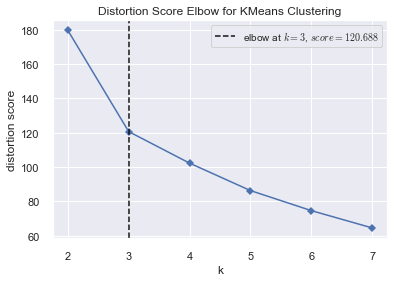

In [57]:
kmeans = KElbowVisualizer(c.KMeans(), k=clusters, timings=False)
kmeans.fit(X)
kmeans.show();

## 7.2 Silhouette Score

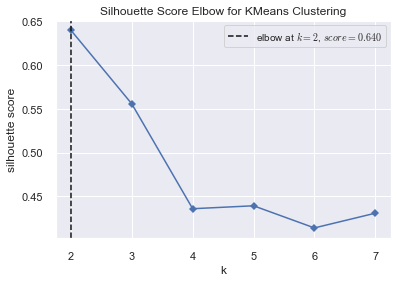

In [58]:
kmeans = KElbowVisualizer(c.KMeans(), k=clusters, metric='silhouette', timings=False)
kmeans.fit(X)

kmeans.show();

## 7.3 Silhouette Analysis

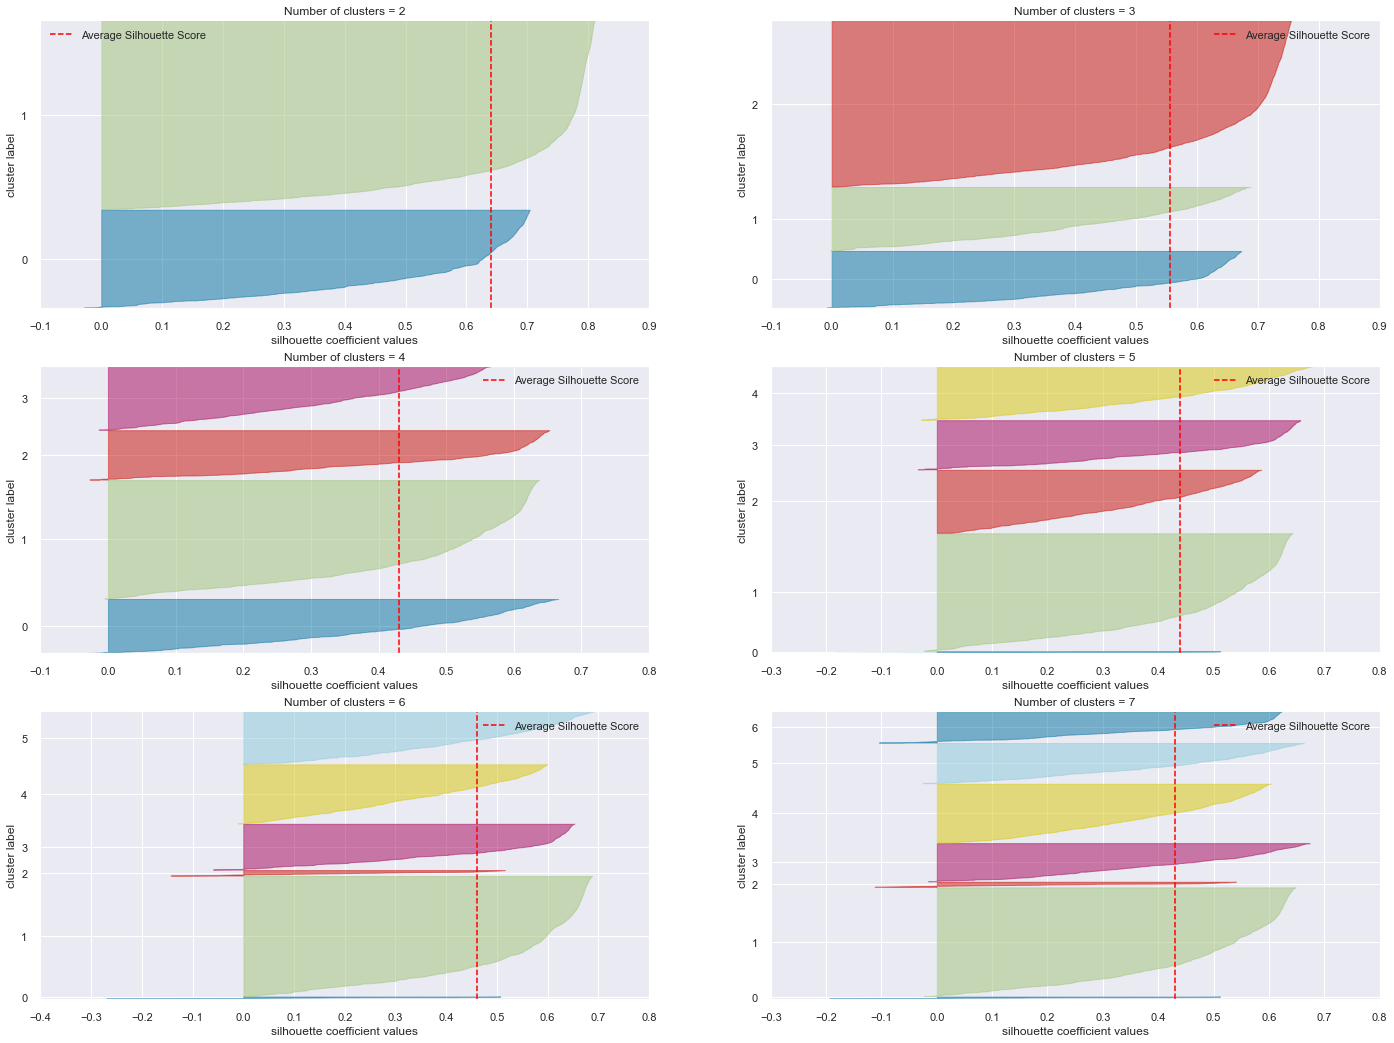

In [59]:
fig, ax = plt.subplots(3, 2, figsize=(24, 18))

for k in clusters:
    km = c.KMeans(n_clusters=k, init='random', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(k, 2)
    
    visualizer =  SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(X)
    visualizer.finalize()
    
ax[0, 0].title.set_text('Number of clusters = 2')
ax[0, 1].title.set_text('Number of clusters = 3')
ax[1, 0].title.set_text('Number of clusters = 4')
ax[1, 1].title.set_text('Number of clusters = 5')
ax[2, 0].title.set_text('Number of clusters = 6')
ax[2, 1].title.set_text('Number of clusters = 7')

plt.show()

# 8.0 MODEL TRAINING

## 8.1 K-Means

In [60]:
# model definition

# keep 4 clusters to analyze with the result of the previous cycle
k = 4          
kmeans = c.KMeans(init='random', n_clusters=k, n_init=10, max_iter=300, random_state=42)

# model training
kmeans.fit(X)

# clustering
labels = kmeans.labels_

## 8.2 Cluster Validation

In [61]:
## WSS 
print(f'WSS: {kmeans.inertia_:.2f}')

## SS
print(f'SS : {m.silhouette_score(X, labels, metric="euclidean"):.2f}')

WSS: 102.40
SS : 0.43


# 9 CLUSTER ANALYSIS

In [62]:
df9 = df_ref.copy()
df9['cluster'] = labels
df9.head()

,customer_id,gross_revenue,mean_ticket,qtd_purchases,qtd_products,avg_products,avg_unique_products,recency_days,purchase_frequency,qtd_cancelled_products,cancelled_over_purchased,cluster
0,17850,5288.63,16.95,34,1733,50.97,0.62,372,17.00,40,0.02,2
1,13047,3089.10,15.92,9,1390,154.44,11.67,56,0.03,35,0.03,3
2,12583,6629.34,28.21,15,5028,335.20,7.60,2,0.04,50,0.01,1
3,13748,948.25,33.87,5,439,87.80,4.80,95,0.02,0,0.00,3
4,15100,635.10,105.85,3,80,26.67,0.33,333,0.07,22,0.28,2


## 9.2 UMAP

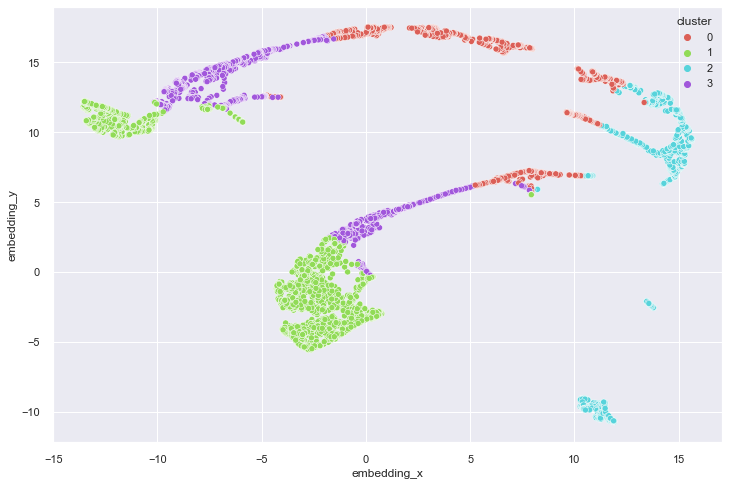

In [63]:
df_viz = df9.drop(columns='customer_id', axis=1)
reducer = umap.UMAP(n_neighbors=40, random_state=42)
embedding = reducer.fit_transform(X)

# embedding
df_viz['embedding_x'] = embedding[:,0]
df_viz['embedding_y'] = embedding[:,1]

# plot UMAP
plt.figure(figsize=(12, 8))
sns.scatterplot(x='embedding_x', 
                y='embedding_y', 
                hue='cluster',
                palette=sns.color_palette('hls', n_colors=len(df_viz['cluster'].unique())),
                data=df_viz);

## 9.3 Cluster Profile

In [64]:
# number of customers
df_cluster = df9[['customer_id', 'cluster']].groupby('cluster').count().reset_index().rename(columns={'customer_id': 'qtd_customers'})
df_cluster['perc_customer'] = df_cluster['qtd_customers'] / (df_cluster['qtd_customers'].sum()) * 100

# gross revenue
df_gross_revenue = df9[['gross_revenue', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_gross_revenue, how='inner', on='cluster' )

# mean ticket
df_ticket = df9[['mean_ticket', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_ticket, how='inner', on='cluster')

# qtd purchases
df_purchases = (df9[['qtd_purchases', 'cluster']].groupby('cluster').mean()
                                                                    .reset_index().rename(columns={'qtd_purchases':'purchases'}))

df_cluster = pd.merge(df_cluster, df_purchases, how='inner', on='cluster')

# qtd products
df_products = (df9[['qtd_products', 'cluster']].groupby('cluster').mean()
                                                                  .reset_index()
                                                                  .rename(columns={'qtd_products':'products'}))

df_cluster = pd.merge(df_cluster, df_products, how='inner', on='cluster')

# qtd unique products
df_unique_products = (df9[['avg_unique_products', 'cluster']].groupby('cluster').mean()
                                                                                .reset_index()
                                                                                .rename(columns={'avg_unique_products':'unique_products'}))

df_cluster = pd.merge(df_cluster, df_unique_products, how='inner', on='cluster')

# recency days
df_recency_days = df9[['recency_days', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_recency_days, how='inner', on='cluster')

# purchased frequency
df_purchased_frequency = df9[['purchase_frequency', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_purchased_frequency, how='inner', on='cluster')

# qtd cancelled products
df_cancelled_products = (df9[['qtd_cancelled_products', 'cluster']].groupby('cluster').mean()
                                                                                      .reset_index()
                                                                                      .rename(columns={'qtd_cancelled_products':'cancelled_products'}))                            

df_cluster = pd.merge(df_cluster, df_cancelled_products, how='inner', on='cluster')

# cancelled products over purchased products
df_cluster['cancelled_over_purchased'] = (df_cluster[['products', 'cancelled_products']]
                                          .apply(lambda x: x['cancelled_products'] / x['products'], axis=1))

In [65]:
df_cluster 

,cluster,qtd_customers,perc_customer,gross_revenue,mean_ticket,purchases,products,unique_products,recency_days,purchase_frequency,cancelled_products,cancelled_over_purchased
0,0,1080,18.94,663.45,33.85,1.49,295.77,40.74,190.83,0.77,11.89,0.04
1,1,2367,41.50,3018.87,28.73,5.97,1783.25,30.17,19.73,0.27,66.99,0.04
2,2,987,17.31,700.65,22.85,1.17,321.16,53.75,311.58,0.96,77.94,0.24
3,3,1269,22.25,989.19,26.66,2.28,566.75,34.69,83.40,0.55,7.43,0.01
